In [1]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [2]:
!jt -t grade3

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.56)
from IPython.core.debugger import set_trace
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_data = df_train.append(df_test)
from IPython.display import display, display_html
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str +=df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw = True)
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\Lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## Base Model

In [4]:
df_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


,Sex,Survived
0,female,0.742
1,male,0.189


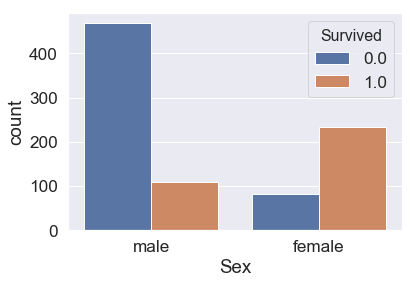

In [5]:
sns.countplot(df_data['Sex'], hue=df_data['Survived'])
display(df_data[["Sex", "Survived"]].groupby(['Sex'], as_index = False).mean().round(3))

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


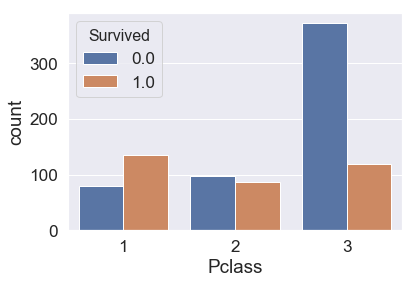

In [6]:
sns.countplot(df_data['Pclass'], hue=df_data['Survived'])
display(df_data[["Pclass", "Survived"]].groupby(['Pclass'], as_index = False).mean().round(3))

In [7]:
df_data['Sex_code'] = df_data['Sex'].map({'female': 1, 'male': 0}).astype('int')

In [8]:
df_train = df_data[:len(df_train)]
df_test = df_test[len(df_train):]

In [9]:
X = df_train.drop(labels=['Survived', 'PassengerId'], axis=1)
Y = df_train['Survived']

In [10]:
Base = ['Sex_code', 'Pclass']
Base_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
Base_Model.fit(X[Base], Y)
print(f'Base oob score :{Base_Model.oob_score_}')

Base oob score :0.7317620650953984


## Fare

In [11]:
df_data['Log_Fare'] = (df_data['Fare'] + 1).map(lambda x: np.log10(x) if x > 0 else 0)
df_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Sex_code,Log_Fare
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0,0.916454
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1,1.859038
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,0.950608
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,1,1.733197
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,0,0.956649


Fare        
Survived    0.0     1.0
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

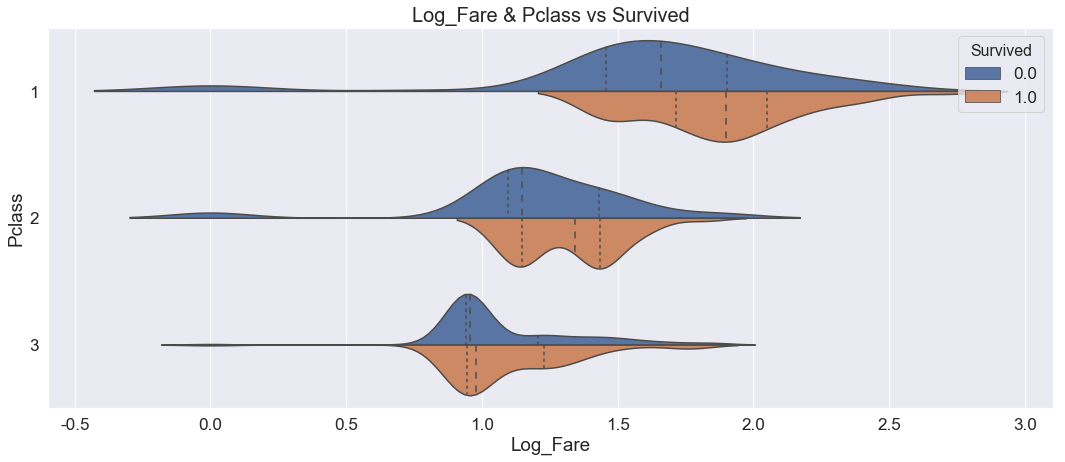

In [12]:
fig, ax = plt.subplots(figsize = (18,7))
sns.violinplot(y = 'Pclass', x='Log_Fare', hue= 'Survived', data=df_data, orient='h', ax=ax, split=True, scale="width", inner="quartile")
ax.set_title('Log_Fare & Pclass vs Survived', fontsize = 20)
pd.pivot_table(df_data, values= ['Fare'], index=['Pclass'], columns=['Survived'], aggfunc='median').round(3)

In [13]:
df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())

In [14]:
df_data['FareBin_4'] = pd.qcut(df_data['Fare'], 4)
df_data['FareBin_5'] = pd.qcut(df_data['Fare'], 5)
df_data['FareBin_6'] = pd.qcut(df_data['Fare'], 6)
df_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Sex_code,Log_Fare,FareBin_4,FareBin_5,FareBin_6
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0,0.916454,"(-0.001, 7.896]","(-0.001, 7.854]","(-0.001, 7.775]"
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1,1.859038,"(31.275, 512.329]","(41.579, 512.329]","(53.1, 512.329]"
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,0.950608,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]"
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,1,1.733197,"(31.275, 512.329]","(41.579, 512.329]","(26.0, 53.1]"
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,0,0.956649,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]"


In [15]:
label = LabelEncoder()
df_data['FareBin_Code_4'] = label.fit_transform(df_data['FareBin_4'])
df_data['FareBin_Code_5'] = label.fit_transform(df_data['FareBin_5'])
df_data['FareBin_Code_6'] = label.fit_transform(df_data['FareBin_6'])
df_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Sex_code,Log_Fare,FareBin_4,FareBin_5,FareBin_6,FareBin_Code_4,FareBin_Code_5,FareBin_Code_6
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0,0.916454,"(-0.001, 7.896]","(-0.001, 7.854]","(-0.001, 7.775]",0,0,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1,1.859038,"(31.275, 512.329]","(41.579, 512.329]","(53.1, 512.329]",3,4,5
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,0.950608,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,1,1.733197,"(31.275, 512.329]","(41.579, 512.329]","(26.0, 53.1]",3,4,4
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,0,0.956649,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1


Pclass,1,2,3
FareBin_Code_4,,,
0,8,6,323
1,0,128,193
2,77,104,147
3,238,39,46
Pclass,1,2,3
FareBin_Code_5,,,
0,8,6,261
1,0,36,218
2,0,124,132


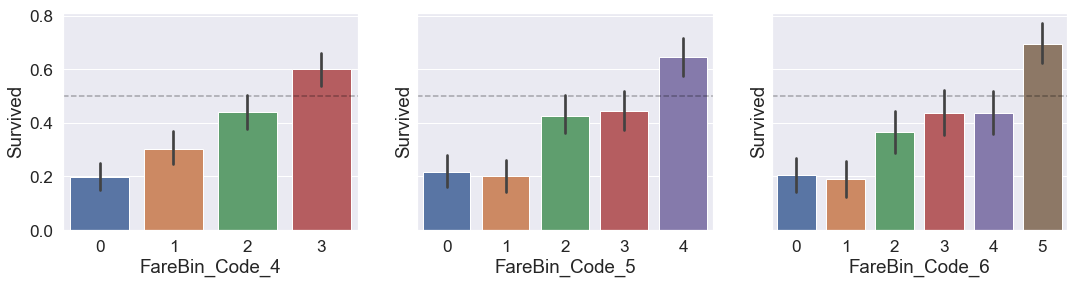

In [16]:
df_4 = pd.crosstab(df_data['FareBin_Code_4'], df_data['Pclass'])
df_5 = pd.crosstab(df_data['FareBin_Code_5'], df_data['Pclass'])
df_6 = pd.crosstab(df_data['FareBin_Code_6'], df_data['Pclass'])
display_side_by_side(df_4, df_5, df_6)

# plots
# fig , [ax1, ax2, ax3] = plt.subplots(1, 3, sharey=True)
fig , ax = plt.subplots(1, 3, sharey=True)
fig.set_figwidth(18)
# for axi in [ax1, ax2, ax3]:
#     axi.axhline(0.5, linestyle='dashed', c='black', alpha = .3)
for i in range(3):
    ax[i].axhline(0.5, linestyle='dashed', c='black', alpha = .3)
g1 = sns.factorplot(x='FareBin_Code_4', y="Survived", data=df_data, kind='bar', ax=ax[0])
g2 = sns.factorplot(x='FareBin_Code_5', y="Survived", data=df_data, kind='bar', ax=ax[1])
g3 = sns.factorplot(x='FareBin_Code_6', y="Survived", data=df_data, kind='bar', ax=ax[2])
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)

In [17]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
X = df_train.drop(labels = ['Survived', 'PassengerId'], axis = 1)
Y = df_train['Survived']
X.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Ticket', 'Sex_code', 'Log_Fare', 'FareBin_4', 'FareBin_5',
       'FareBin_6', 'FareBin_Code_4', 'FareBin_Code_5', 'FareBin_Code_6'],
      dtype='object')

In [18]:
compare = ['Sex_code', 'Pclass', 'FareBin_Code_4', 'FareBin_Code_5', 'FareBin_Code_6']
selector = RFECV(RandomForestClassifier(n_estimators = 250, min_samples_split = 20), cv=10, n_jobs= -1)
selector.fit(X[compare], Y)
print(selector.support_)
print(selector.ranking_)
print(selector.grid_scores_*100)

[ True  True  True  True  True]
[1 1 1 1 1]
[78.66981614 77.33398593 79.57371467 79.68862785 80.14308819]


In [19]:
score_b4, score_b5, score_b6 = [], [], []
seeds = 10
for i in range(seeds):
    diff_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
    selector = RFECV(RandomForestClassifier(random_state = i , n_estimators = 250, min_samples_split = 20),
                     cv = diff_cv, n_jobs= -10)
    selector.fit(X[compare], Y)
    score_b4.append(selector.grid_scores_[2])
    score_b5.append(selector.grid_scores_[3])
    score_b6.append(selector.grid_scores_[4])

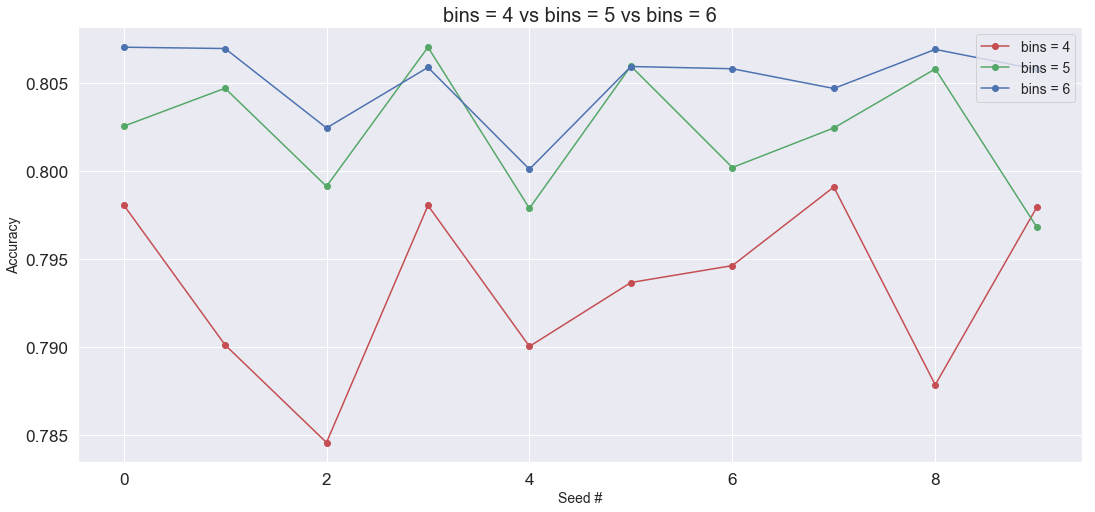

In [20]:
score_list = [score_b4, score_b5, score_b6]
for item in score_list:
    item = np.array(item*100)
fig = plt.figure(figsize=(18,8))
ax = plt.gca()
ax.plot(range(seeds), score_b4, '-or', label='bins = 4')
ax.plot(range(seeds), score_b5, '-og', label='bins = 5')
ax.plot(range(seeds), score_b6, '-ob', label='bins = 6')
ax.set_xlabel('Seed #', fontsize = '14')
ax.set_ylabel('Accuracy', fontsize = '14')
ax.set_title('bins = 4 vs bins = 5 vs bins = 6', fontsize = '20')
plt.legend(fontsize = 14, loc = 'upper right')


In [21]:
b4, b5, b6 = ['Sex_code', 'Pclass', 'FareBin_Code_4'],  ['Sex_code', 'Pclass', 'FareBin_Code_5'],  ['Sex_code', 'Pclass', 'FareBin_Code_6'],
b4_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b4_Model.fit(X[b4], Y)
b5_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b5_Model.fit(X[b5], Y)
b6_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b6_Model.fit(X[b6], Y)
print('b4 oob score :%.5f' % (b4_Model.oob_score_))
print('b5 oob score :%.5f' % (b5_Model.oob_score_))
print('b6 oob score :%.5f' % (b6_Model.oob_score_))

b4 oob score :0.80584
b5 oob score :0.81033
b6 oob score :0.80135


## Connected_Survival

In [22]:
df_train['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

In [23]:
df_data['Family_size'] = df_data['SibSp'] + df_data['Parch'] + 1
df_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket,Sex_code,Log_Fare,FareBin_4,FareBin_5,FareBin_6,FareBin_Code_4,FareBin_Code_5,FareBin_Code_6,Family_size
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,A/5 21171,0,0.916454,"(-0.001, 7.896]","(-0.001, 7.854]","(-0.001, 7.775]",0,0,0,2
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,PC 17599,1,1.859038,"(31.275, 512.329]","(41.579, 512.329]","(53.1, 512.329]",3,4,5,2
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,STON/O2. 3101282,1,0.950608,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,113803,1,1.733197,"(31.275, 512.329]","(41.579, 512.329]","(26.0, 53.1]",3,4,4,2
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,373450,0,0.956649,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1,1


In [24]:
deplicate_ticket = []
for tk in df_data.Ticket.unique():
    tem = df_data.loc[df_data.Ticket == tk, 'Fare']
    if tem.count() > 1:
        deplicate_ticket.append(df_data.loc[df_data.Ticket == tk, ['Name', 'Ticket', 'Fare', 'Cabin', 'Family_size', 'Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(20)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


In [25]:
df_fri = deplicate_ticket.loc[(deplicate_ticket.Family_size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.Family_size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(df_fri, df_fami)
print('people keep the same ticket: %.0f' % len(deplicate_ticket))
print('friend: %.0f' % len(deplicate_ticket[deplicate_ticket.Family_size == 1]))
print('Family: %.0f' % len(deplicate_ticket[deplicate_ticket.Family_size > 1]))

,Name,Ticket,Fare,Cabin,Family_size,Survived
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
20,"Fynney, Mr. Joseph J",239865,26.0000,NaN,1,0.0
791,"Gaskell, Mr. Alfred",239865,26.0000,NaN,1,0.0
195,"Lurette, Miss. Elise",PC 17569,146.5208,B80,1,1.0
681,"Hassab, Mr. Hammad",PC 17572,76.7292,D49,1,1.0
61,"Icard, Miss. Amelie",113572,80.0000,B28,1,1.0
829,"Stone, Mrs. George Nelson (Martha Evelyn)",113572,80.0000,B28,1,1.0


,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


people keep the same ticket: 596
friend: 127
Family: 469


In [26]:
deplicate_ticket = []
for tk in df_data.Ticket.unique():
    tem = df_data.loc[df_data.Ticket == tk, 'Fare']
    if tem.count() > 1:
        deplicate_ticket.append(df_data.loc[df_data.Ticket==tk,['Name', 'Ticket', 'Fare', 'Cabin', 'Family_size', 'Survived']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(20)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


In [27]:
df_data['Connected_Survival'] = 0.5
for _, df_grp in df_data.groupby('Ticket'):
    if len(df_grp)>1:
        for index, row in df_grp.iterrows():
            smax = df_grp.drop(index)['Survived'].max()
            smin = df_grp.drop(index)['Survived'].min()
            passID = row['PassengerId']
            if smax == 1.0:
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif smin == 0.0:
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 0
print(f'people keep the same ticket: {len(deplicate_ticket)}')
print('people have connect infomation : %.0f' % (df_data[df_data['Connected_Survival']!=0.5].shape[0]))
df_data.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596
people have connect infomation : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [28]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
X = df_train.drop(labels=['Survived', 'PassengerId'], axis=1)
Y = df_train['Survived']

In [29]:
connect = ['Sex_code', 'Pclass', 'FareBin_Code_5', 'Connected_Survival']
connect_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
connect_Model.fit(X[connect], Y)
print('connect oob score :%.5f' % connect_Model.oob_score_)

connect oob score :0.82043


## Age

Sex,female,male,All
Has_Age,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


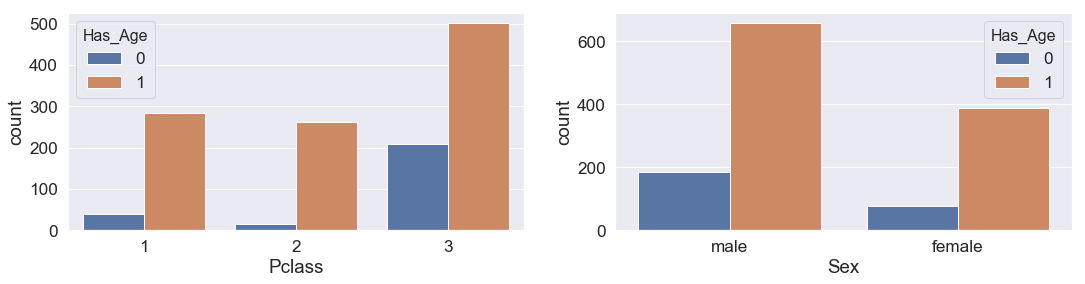

In [30]:
df_data['Has_Age'] = df_data['Age'].isnull().map(lambda x :0 if x == True else 1)
fig, ax = plt.subplots(1,2)
fig.set_figwidth(18)
ax1 = sns.countplot(df_data['Pclass'], hue=df_data['Has_Age'], ax = ax[0])
ax2 = sns.countplot(df_data['Sex'], hue = df_data['Has_Age'], ax = ax[1])
pd.crosstab(df_data['Has_Age'], df_data['Sex'], margins=True).round(3)

In [31]:
Mask_Has_Age_P12_Survived = (df_data.Has_Age == 1) & (df_data.Pclass != 3) & (df_data.Survived == 1)
Mask_Has_Age_P12_Dead =  (df_data.Has_Age == 1) & (df_data.Pclass != 3) & (df_data.Survived == 0)

Text(0.5, 1.0, 'Age vs Survived in Pclass =1 and 2')

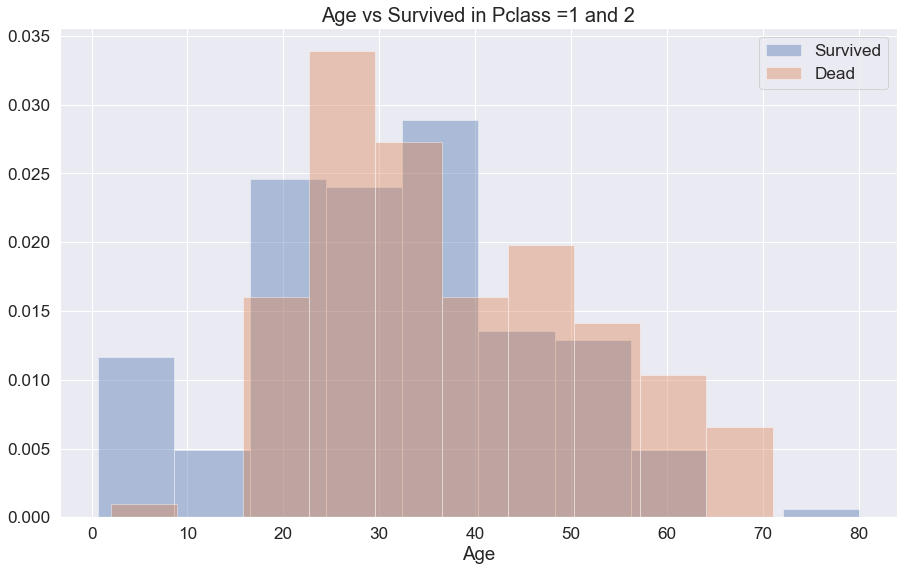

In [32]:
fig, ax = plt.subplots(figsize = (15,9))
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Survived, 'Age'], kde=False, bins=10, norm_hist=True, label='Survived')
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Dead, 'Age'], kde=False, bins=10, norm_hist= True, label='Dead')
ax.legend()
ax.set_title('Age vs Survived in Pclass =1 and 2', fontsize = 20)

In [33]:
df_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Log_Fare,FareBin_4,FareBin_5,FareBin_6,FareBin_Code_4,FareBin_Code_5,FareBin_Code_6,Family_size,Connected_Survival,Has_Age
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,0.916454,"(-0.001, 7.896]","(-0.001, 7.854]","(-0.001, 7.775]",0,0,0,2,0.5,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,1.859038,"(31.275, 512.329]","(41.579, 512.329]","(53.1, 512.329]",3,4,5,2,0.5,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,0.950608,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1,1,0.5,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,1.733197,"(31.275, 512.329]","(41.579, 512.329]","(26.0, 53.1]",3,4,4,2,0.0,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,0.956649,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1,1,0.5,1


In [34]:
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
df_data.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,FareBin_4,FareBin_5,FareBin_6,FareBin_Code_4,FareBin_Code_5,FareBin_Code_6,Family_size,Connected_Survival,Has_Age,Title
413,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,...,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1,1,0.5,0,Mr
414,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,...,"(31.275, 512.329]","(41.579, 512.329]","(53.1, 512.329]",3,4,5,1,1.0,1,Dona
415,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,...,"(-0.001, 7.896]","(-0.001, 7.854]","(-0.001, 7.775]",0,0,0,1,0.5,1,Mr
416,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,...,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1,1,0.5,0,Mr
417,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,...,"(14.454, 31.275]","(21.558, 41.579]","(14.454, 26.0]",2,3,3,3,1.0,0,Master


In [35]:
df_data["Title"] = df_data['Title'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Dona', 'Jonkheer',
                                            'Major', 'Rev', 'Sir'], 'Rare')
df_data['Title'] = df_data['Title'].replace(['Mile', 'Ms', 'Mme'], 'Miss')
df_data['Title'] = df_data['Title'].replace(['Lady'], 'Mrs')
df_data['Title'] = df_data['Title'].map({"Mr":0, "Rare":1, "Master":2, "Miss":3, "Mrs":4})
Ti = df_data.groupby('Title')['Age'].median()
Ti

Title
0.0    29.0
1.0    47.0
2.0     4.0
3.0    22.0
4.0    36.0
Name: Age, dtype: float64

In [45]:
Ti_pred = df_data.groupby('Title')['Age'].median().values
df_data['Ti_Age'] = df_data['Age']
for i in range(5):
    df_data.loc[(df_data.Age.isnull()) & (df_data.Title == i), 'Ti_Age'] = Ti_pred[i]
df_data['Ti_Age'] = df_data['Ti_Age'].astype('int')
df_data['Ti_Minor'] = ((df_data['Ti_Age']) < 16.0) *1

In [47]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
X = df_train.drop(labels=['Survived', 'PassengerId'], axis=1)
Y = df_train['Survived']

In [48]:
minor = ['Sex_code', 'Pclass', 'FareBin_Code_5', 'Connected_Survival', 'Ti_Minor']
minor_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
minor_Model.fit(X[minor], Y)
print('minor oob score :%.5f' % minor_Model.oob_score_)

minor oob score :0.84175


## Family_size

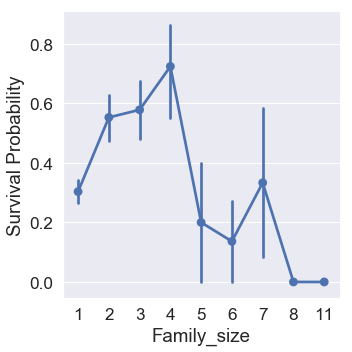

In [56]:
g = sns.factorplot(x='Family_size', y='Survived', data=df_data)
g = g.set_ylabels('Survival Probability')

In [57]:
df_data['L_Family'] = df_data['Family_size'].apply(lambda x: 0 if x <= 4 else 1 ).astype(int)
df_data.loc[df_data['Family_size'] == 1, 'FamilyClass'] = 0
df_data.loc[(df_data['Family_size'] <= 4) & (df_data['Family_size']>1), 'FamilyClass'] = 1
df_data.loc[df_data['Family_size'] >= 5, 'FamilyClass'] = 2
df_data['FamilyClass'] = df_data['FamilyClass'].astype(int)
df_data[['FamilyClass', 'Survived']].groupby(['FamilyClass']).mean()

,Survived
FamilyClass,
0,0.303538
1,0.578767
2,0.161290


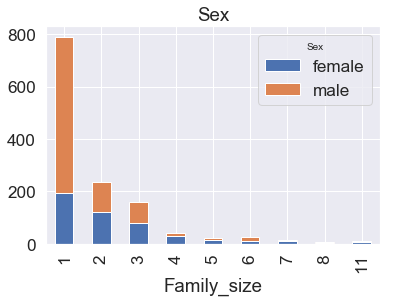

In [60]:
pd.crosstab(df_data['Family_size'], df_data['Sex']).plot(kind='bar', stacked=True, title="Sex")

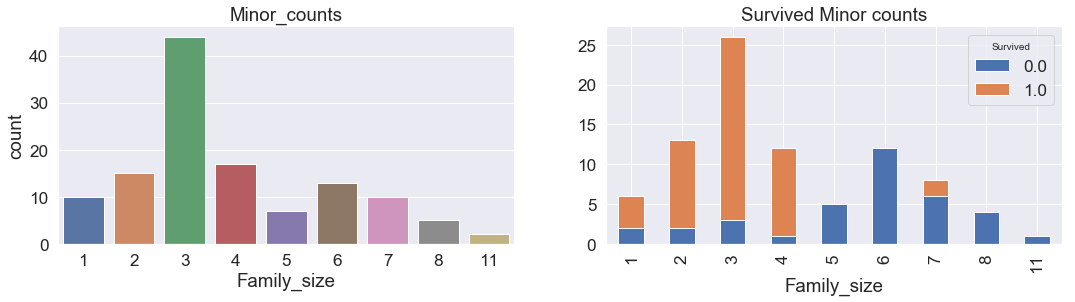

In [66]:
Minor_mask = df_data.Ti_Minor == 1
fig, ax = plt.subplots(1,2)
fig.set_figwidth(18)
sns.countplot(df_data[Minor_mask]['Family_size'], ax=ax[0])
ax[0].set_title('Minor_counts')
pd.crosstab(df_data[Minor_mask]['Family_size'], df_data[Minor_mask]['Survived'])\
.plot(kind='bar', stacked=True, title="Survived Minor counts", ax = ax[1])